In [1]:
# --- Notebook setup ---
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# >>> EDIT if needed <<<
BASE = Path("/home/skataoka26/COSC_498/miniMXE")
RESULTS_DIR = BASE / "results"

# Colors (feel free to change or remove)
C_SRAM = "#4C78A8"
C_JANS = "#F58518"


In [2]:
def num(s):
    return pd.to_numeric(s, errors="coerce")

def bench_under_to_dot(b):
    return b.replace("_", ".", 1)

def parse_run_meta(run_name: str):
    """
    Works with:
      - sweep_cap_s4m_j2m_20250920T023648Z
      - detailed_leela_s8m_j4m_20250920T023630Z
      - ...and '...sram8MB...jans4MB...' styles
    """
    sram = None; jans = None
    m = re.search(r"s(\d+)m\b", run_name, re.I)
    if m: sram = int(m.group(1))
    m = re.search(r"j(\d+)m\b", run_name, re.I)
    if m: jans = int(m.group(1))
    if sram is None:
        m = re.search(r"sram\s*(\d+)\s*mb", run_name, re.I)
        if m: sram = int(m.group(1))
    if jans is None:
        m = re.search(r"jans\s*(\d+)\s*mb", run_name, re.I)
        if m: jans = int(m.group(1))
    ts = None
    m = re.search(r"(\d{8}T\d{6}Z)", run_name)
    if m: ts = m.group(1)
    kind = "detailed" if "detailed" in run_name.lower() else ("sweep" if "sweep" in run_name.lower() else "other")
    return sram, jans, ts, kind

def discover_run_dirs(results_dir: Path, include_substrings=None):
    """Return run dirs that already contain output_* folders; optional substring filter."""
    out = []
    for p in results_dir.iterdir():
        if not p.is_dir():
            continue
        if include_substrings and not any(sub in p.name for sub in include_substrings):
            continue
        if any(p.glob("output_*")):
            out.append(p)
    return sorted(out, key=lambda x: x.name)


In [3]:
def load_one_run(run_dir: Path):
    out_dirs = sorted(run_dir.glob("output_*"))
    if not out_dirs:
        raise FileNotFoundError(f"No output_* in {run_dir}")

    sram_mb, jans_mb, ts, kind = parse_run_meta(run_dir.name)

    energy_rows, summary_rows = [], []
    for od in out_dirs:
        e_csv = od / "energy_bounds.csv"
        s_csv = od / "summary.csv"

        if e_csv.is_file():
            e = pd.read_csv(e_csv)
            if "benchmark" not in e.columns:
                e["benchmark"] = od.name.replace("output_", "")
            e["benchmark"] = e["benchmark"].astype(str)
            e["config"] = e["config"].astype(str).str.strip()
            energy_rows.append(e)

        if s_csv.is_file():
            s = pd.read_csv(s_csv)
            if "benchmark" not in s.columns:
                s["benchmark"] = od.name.replace("output_", "")
            s["benchmark"] = s["benchmark"].astype(str)
            s["config"] = s["config"].astype(str).str.strip()
            summary_rows.append(s)

    if not energy_rows:
        raise RuntimeError(f"No energy_bounds.csv in {run_dir}")
    if not summary_rows:
        raise RuntimeError(f"No summary.csv in {run_dir}")

    energy = pd.concat(energy_rows, ignore_index=True)
    summary = pd.concat(summary_rows, ignore_index=True)

    # numeric coercion (energy)
    for col in ["time_s","leak_J","energy_exact_J","dyn_lower_nJ","dyn_upper_nJ",
                "l3_accesses","l3_misses_db","l3_read_hits","l3_write_hits","l3_writebacks","l3_evictions"]:
        if col in energy.columns:
            energy[col] = num(energy[col])

    # bounds + best energy
    if {"dyn_lower_nJ","dyn_upper_nJ","leak_J"}.issubset(energy.columns):
        energy["E_lo_J"] = energy["dyn_lower_nJ"]*1e-9 + energy["leak_J"]
        energy["E_hi_J"] = energy["dyn_upper_nJ"]*1e-9 + energy["leak_J"]
    else:
        energy["E_lo_J"] = np.nan
        energy["E_hi_J"] = np.nan

    ez = energy.get("energy_exact_J")
    if ez is None:
        energy["E_best_J"] = (energy["E_lo_J"] + energy["E_hi_J"]) / 2.0
    else:
        energy["E_best_J"] = np.where(ez.notna() & (ez > 0), ez, (energy["E_lo_J"] + energy["E_hi_J"]) / 2.0)

    # derived miss rate / write-hit share
    if {"l3_accesses","l3_misses_db"}.issubset(energy.columns):
        energy["miss_rate_db"] = np.where(energy["l3_accesses"] > 0,
                                          energy["l3_misses_db"] / energy["l3_accesses"], np.nan)
    else:
        energy["miss_rate_db"] = np.nan

    hits_total = energy.get("l3_read_hits", 0) + energy.get("l3_write_hits", 0)
    if "l3_write_hits" in energy.columns:
        energy["write_hit_share"] = np.where(hits_total > 0, energy["l3_write_hits"]/hits_total, np.nan)
    else:
        energy["write_hit_share"] = np.nan

    # summary numerics
    for col in ["instructions","cycles","ipc","time_ns",
                "l3_accesses_db","l3_misses_db","l3_read_hits","l3_write_hits",
                "avg_l3_hit_ns","l3_uncore_requests",
                "rd_hit_cycles","wr_hit_cycles","core_period_ns"]:
        if col in summary.columns:
            summary[col] = num(summary[col])

    # keys + categories
    energy["bench_feat_key"]  = energy["benchmark"].map(bench_under_to_dot)
    summary["bench_feat_key"] = summary["benchmark"].map(bench_under_to_dot)
    cat = pd.CategoricalDtype(categories=["SRAM","JanS"], ordered=True)
    energy["config"] = energy["config"].astype(cat)
    summary["config"] = summary["config"].astype(cat)

    # tag run meta
    for df in (energy, summary):
        df["run_id"] = run_dir.name
        df["sram_MB"] = sram_mb
        df["jans_MB"] = jans_mb
        df["timestamp"] = ts
        df["kind"] = kind

    return energy, summary


In [4]:
# Optionally filter to only sweep folders:
INCLUDE = None  # e.g., ["sweep_cap_"] or ["sweep_cap_", "detailed_leela_"]

run_dirs = discover_run_dirs(RESULTS_DIR, INCLUDE)
if not run_dirs:
    raise SystemExit(f"No runs found under: {RESULTS_DIR}")

print("Discovered runs:")
for rd in run_dirs:
    sram, jans, ts, kind = parse_run_meta(rd.name)
    print(f"  - {rd.name}  (SRAM={sram}MB, JanS={jans}MB, ts={ts}, kind={kind})")

energies, summaries = [], []
for rd in run_dirs:
    try:
        e, s = load_one_run(rd)
        energies.append(e); summaries.append(s)
    except Exception as ex:
        print(f"[WARN] skipping {rd.name}: {ex}")

if not energies:
    raise SystemExit("No readable runs after loading attempts.")

energy_all  = pd.concat(energies, ignore_index=True)
summary_all = pd.concat(summaries, ignore_index=True)

display(energy_all.head())
display(summary_all.head())


Discovered runs:
  - detailed_leela_s8m_j4m_20250920T023630Z  (SRAM=NoneMB, JanS=NoneMB, ts=20250920T023630Z, kind=detailed)
  - spec_roi100_nowarm_sram8MB_rd4_wr2_jans4MB_rd6_wr17_20250919T230616Z  (SRAM=8MB, JanS=4MB, ts=20250919T230616Z, kind=other)
  - spec_roi100_warm30_sram8MB_rd4_wr2_jans4MB_rd6_wr17_20250919T002148Z  (SRAM=8MB, JanS=4MB, ts=20250919T002148Z, kind=other)
  - sweep_cap_s4m_j2m_20250920T023648Z  (SRAM=NoneMB, JanS=NoneMB, ts=20250920T023648Z, kind=sweep)
  - sweep_cap_s4m_j4m_20250920T023649Z  (SRAM=NoneMB, JanS=NoneMB, ts=20250920T023649Z, kind=sweep)
  - sweep_cap_s4m_j8m_20250920T023650Z  (SRAM=NoneMB, JanS=NoneMB, ts=20250920T023650Z, kind=sweep)
  - sweep_cap_s8m_j2m_20250920T023651Z  (SRAM=NoneMB, JanS=NoneMB, ts=20250920T023651Z, kind=sweep)
  - sweep_cap_s8m_j4m_20250920T023652Z  (SRAM=NoneMB, JanS=NoneMB, ts=20250920T023652Z, kind=sweep)
  - sweep_cap_s8m_j8m_20250920T023653Z  (SRAM=NoneMB, JanS=NoneMB, ts=20250920T023653Z, kind=sweep)


,benchmark,n_m,config,time_s,l3_accesses,l3_misses_db,l3_read_hits,l3_write_hits,l3_writebacks,l3_evictions,leak_W,leak_J,dyn_exact_nJ,energy_exact_J,ed2p_exact_J_s2,dyn_lower_nJ,dyn_upper_nJ,energy_lower_J,energy_upper_J,ed2p_lower_J_s2,ed2p_upper_J_s2,energy_scope,exact_source,notes,E_lo_J,E_hi_J,E_best_J,miss_rate_db,write_hit_share,bench_feat_key,run_id,sram_MB,jans_MB,timestamp,kind
0,541_leela_r,500,SRAM,6.195308,26724776,2784505,14487112,9453159,1472192,2454569,3.438,21.299470,13292194,21.312762,818.023091,13667020,12991126,21.313137,21.312461,818.037478,818.011536,llc_only,sqlite,ok,21.313137,21.312461,21.312762,0.104192,0.394864,541.leela_r,detailed_leela_s8m_j4m_20250920T023630Z,None,None,20250920T023630Z,detailed
1,541_leela_r,500,JanS,6.458662,27033846,21968652,4752454,312740,10984496,21101727,0.048,0.310016,3305913,0.313322,13.070001,2732781,15152030,0.312749,0.325168,13.046094,13.564154,llc_only,sqlite,ok,0.312749,0.325168,0.313322,0.812635,0.061743,541.leela_r,detailed_leela_s8m_j4m_20250920T023630Z,None,None,20250920T023630Z,detailed
2,520_omnetpp_r,100,SRAM,0.034504,120057,64727,52887,2443,0,0,3.438,0.118624,31905,0.118656,0.000141,32426,30853,0.118656,0.118655,0.000141,0.000141,llc_only,sqlite,ok,0.118656,0.118655,0.118656,0.539136,0.044153,520.omnetpp_r,spec_roi100_nowarm_sram8MB_rd4_wr2_jans4MB_rd6...,8,4,20250919T230616Z,other
3,520_omnetpp_r,100,JanS,0.034492,120057,64727,52887,2443,548,2326,0.048,0.001656,20558,0.001676,0.000002,15477,134338,0.001671,0.001790,0.000002,0.000002,llc_only,sqlite,ok,0.001671,0.001790,0.001676,0.539136,0.044153,520.omnetpp_r,spec_roi100_nowarm_sram8MB_rd4_wr2_jans4MB_rd6...,8,4,20250919T230616Z,other
4,531_deepsjeng_r,100,SRAM,0.623602,22710570,22708029,2312,229,22563630,22573694,3.438,2.143943,251218,2.144194,0.833832,253024,252862,2.144196,2.144196,0.833833,0.833833,llc_only,sqlite,ok,2.144196,2.144196,2.144194,0.999888,0.090122,531.deepsjeng_r,spec_roi100_nowarm_sram8MB_rd4_wr2_jans4MB_rd6...,8,4,20250919T230616Z,other


,timestamp_utc,benchmark,n_m,config,instructions,cycles,ipc,time_ns,l3_acc_text,l3_miss_text,l3_miss_rate_pct,dram_acc,dram_lat_value,dram_lat_unit,outdir,l3_accesses_db,l3_misses_db,l3_read_hits,l3_write_hits,l3_writebacks,l3_evictions,l3_misses_custom,l3_total_latency_ns,l3_mshr_latency_ns,l3_snoop_latency_ns,l3_qbs_latency_ns,l3_uncore_time_sum_ns,l3_uncore_requests,avg_uncore_time_per_req_ns,rd_hit_cycles,wr_hit_cycles,core_period_ns,avg_l3_hit_ns,bench_feat_key,run_id,sram_MB,jans_MB,timestamp,kind
0,2025-09-20T14:39:10Z,541_leela_r,500,SRAM,21625023837,16479519812,1.31,6195308200,26724776,2585701,9.68,NaN,NaN,NaN,/home/skataoka26/COSC_498/miniMXE/results/deta...,26724776,2784505,14487112,9453159,1472192,2454569,2585641,0,0,714284100,0,1.017020e+17,2585641,3.933337e+10,4,2,0.37594,1.206869,541.leela_r,detailed_leela_s8m_j4m_20250920T023630Z,None,None,20250920T023630Z,detailed
1,2025-09-20T14:39:10Z,541_leela_r,500,JanS,21625023836,17180041718,1.26,6458662300,27033846,21167408,78.30,NaN,NaN,NaN,/home/skataoka26/COSC_498/miniMXE/results/deta...,27033846,21968652,4752454,312740,10984496,21101727,21167263,0,0,594284371200,0,3.971220e+16,21167263,1.876114e+09,6,17,0.37594,2.510967,541.leela_r,detailed_leela_s8m_j4m_20250920T023630Z,None,None,20250920T023630Z,detailed
2,2025-09-20T01:07:19Z,520_omnetpp_r,100,SRAM,99999894,91780108,1.09,34503800,120057,63911,53.23,NaN,NaN,NaN,/home/skataoka26/COSC_498/miniMXE/results/spec...,120057,64727,52887,2443,0,0,63901,0,0,0,0,NaN,63901,NaN,4,2,0.37594,1.470561,520.omnetpp_r,spec_roi100_nowarm_sram8MB_rd4_wr2_jans4MB_rd6...,8,4,20250919T230616Z,other
3,2025-09-20T01:07:19Z,520_omnetpp_r,100,JanS,99999894,91748720,1.09,34492000,120057,63911,53.23,NaN,NaN,NaN,/home/skataoka26/COSC_498/miniMXE/results/spec...,120057,64727,52887,2443,548,2326,63901,0,0,0,0,NaN,63901,NaN,6,17,0.37594,2.438228,520.omnetpp_r,spec_roi100_nowarm_sram8MB_rd4_wr2_jans4MB_rd6...,8,4,20250919T230616Z,other
4,2025-09-20T01:07:18Z,531_deepsjeng_r,100,SRAM,99999886,1658780522,0.06,623601700,22710570,22704779,99.97,NaN,NaN,NaN,/home/skataoka26/COSC_498/miniMXE/results/spec...,22710570,22708029,2312,229,22563630,22573694,22704766,0,0,0,0,NaN,22704766,NaN,4,2,0.37594,1.435998,531.deepsjeng_r,spec_roi100_nowarm_sram8MB_rd4_wr2_jans4MB_rd6...,8,4,20250919T230616Z,other


In [5]:
def build_bench_metrics_across_runs(energy_df: pd.DataFrame):
    e = energy_df.copy()
    index = ["run_id","sram_MB","jans_MB","benchmark"]

    def piv(col):
        if col not in e.columns:
            return pd.DataFrame(index=e.set_index(index).index.unique())
        return e.pivot_table(index=index, columns="config", values=col, aggfunc="first")

    e_piv = piv("E_best_J")
    t_piv = piv("time_s")
    rh_p  = piv("l3_read_hits")
    wh_p  = piv("l3_write_hits")
    mr_p  = piv("miss_rate_db")

    out = pd.DataFrame(index=e_piv.index)
    out["E_SRAM_J"] = e_piv.get("SRAM")
    out["E_JanS_J"] = e_piv.get("JanS")
    out["T_SRAM_s"] = t_piv.get("SRAM")
    out["T_JanS_s"] = t_piv.get("JanS")
    out["RH_SRAM"]  = rh_p.get("SRAM")
    out["RH_JanS"]  = rh_p.get("JanS")
    out["WH_SRAM"]  = wh_p.get("SRAM")
    out["WH_JanS"]  = wh_p.get("JanS")
    out["MR_SRAM"]  = mr_p.get("SRAM")
    out["MR_JanS"]  = mr_p.get("JanS")
    out = out.reset_index()

    # Ratios / shares
    out["energy_ratio_JanS_over_SRAM"] = out["E_JanS_J"] / out["E_SRAM_J"]
    out["speedup_SRAM_over_JanS"]      = out["T_SRAM_s"] / out["T_JanS_s"]  # >1 ⇒ JanS faster
    out["write_hit_share_SRAM"]        = out["WH_SRAM"] / (out["RH_SRAM"] + out["WH_SRAM"])
    out["write_hit_share_JanS"]        = out["WH_JanS"] / (out["RH_JanS"] + out["WH_JanS"])
    return out

bench_metrics_all = build_bench_metrics_across_runs(energy_all)
display(bench_metrics_all.head())

# Optionally save tidy CSVs in a subfolder
OUTDIR = RESULTS_DIR / "_explore"
OUTDIR.mkdir(parents=True, exist_ok=True)
bench_metrics_all.to_csv(OUTDIR / "bench_metrics_all_runs.csv", index=False)
energy_all.to_csv(OUTDIR / "energy_all_rows.csv", index=False)
summary_all.to_csv(OUTDIR / "summary_all_rows.csv", index=False)
print(f"[saved] {OUTDIR/'bench_metrics_all_runs.csv'}")


,run_id,sram_MB,jans_MB,benchmark,E_SRAM_J,E_JanS_J,T_SRAM_s,T_JanS_s,RH_SRAM,RH_JanS,WH_SRAM,WH_JanS,MR_SRAM,MR_JanS,energy_ratio_JanS_over_SRAM,speedup_SRAM_over_JanS,write_hit_share_SRAM,write_hit_share_JanS
0,spec_roi100_nowarm_sram8MB_rd4_wr2_jans4MB_rd6...,8,4,520_omnetpp_r,0.118656,0.001676,0.034504,0.034492,52887,52887,2443,2443,0.539136,0.539136,0.014125,1.000348,0.044153,0.044153
1,spec_roi100_nowarm_sram8MB_rd4_wr2_jans4MB_rd6...,8,4,531_deepsjeng_r,2.144194,0.031126,0.623602,0.612006,2312,2285,229,229,0.999888,0.999889,0.014516,1.018948,0.090122,0.091090
2,spec_roi100_nowarm_sram8MB_rd4_wr2_jans4MB_rd6...,8,4,541_leela_r,0.068090,0.000960,0.019804,0.019782,1326,1326,2959,2959,0.915044,0.915044,0.014099,1.001112,0.690548,0.690548
3,spec_roi100_nowarm_sram8MB_rd4_wr2_jans4MB_rd6...,8,4,648_exchange2_s,0.062839,0.000878,0.018278,0.018259,788,788,81,81,0.934730,0.934730,0.013972,1.001041,0.093211,0.093211
4,spec_roi100_warm30_sram8MB_rd4_wr2_jans4MB_rd6...,8,4,520_omnetpp_r,14.047035,0.227221,4.077460,4.187316,43357993,37414878,6647013,6016388,0.545186,0.614361,0.016176,0.973765,0.132927,0.138527


[saved] /home/skataoka26/COSC_498/miniMXE/results/_explore/bench_metrics_all_runs.csv


In [8]:
def _sizefig(nbars, base=8, per=0.5, height=4.5):
    return (max(base, nbars*per), height)

def plot_per_run_runtime_bars(bench_metrics_all, run_id, topk=None):
    df = bench_metrics_all[bench_metrics_all["run_id"]==run_id].dropna(subset=["T_SRAM_s","T_JanS_s"]).copy()
    if df.empty:
        print(f"[no data] {run_id}"); return
    df = df.sort_values("benchmark")
    if isinstance(topk, int): df = df.head(topk)
    x = np.arange(len(df)); w = 0.42
    plt.figure(figsize=_sizefig(len(df)))
    plt.bar(x - w/2, df["T_SRAM_s"], width=w, label="SRAM", color=C_SRAM)
    plt.bar(x + w/2, df["T_JanS_s"], width=w, label="JanS", color=C_JANS)
    plt.ylabel("Runtime (s)")
    plt.title(f"Runtime by benchmark — {run_id}")
    plt.xticks(x, df["benchmark"], rotation=45, ha="right"); plt.legend(); plt.tight_layout(); plt.show()

def plot_per_run_energy_bars(bench_metrics_all, run_id, topk=None):
    df = bench_metrics_all[bench_metrics_all["run_id"]==run_id].dropna(subset=["E_SRAM_J","E_JanS_J"]).copy()
    if df.empty:
        print(f"[no data] {run_id}"); return
    df = df.sort_values("benchmark")
    if isinstance(topk, int): df = df.head(topk)
    x = np.arange(len(df)); w = 0.42
    plt.figure(figsize=_sizefig(len(df)))
    plt.bar(x - w/2, df["E_SRAM_J"], width=w, label="SRAM", color=C_SRAM)
    plt.bar(x + w/2, df["E_JanS_J"], width=w, label="JanS", color=C_JANS)
    plt.ylabel("LLC Energy (J)")
    plt.title(f"Energy by benchmark — {run_id}")
    plt.xticks(x, df["benchmark"], rotation=45, ha="right"); plt.legend(); plt.tight_layout(); plt.show()

def plot_per_run_speedup_bars(bench_metrics_all, run_id, topk=None):
    df = bench_metrics_all[bench_metrics_all["run_id"]==run_id].dropna(subset=["speedup_SRAM_over_JanS"]).copy()
    if df.empty:
        print(f"[no data] {run_id}"); return
    df = df.sort_values("speedup_SRAM_over_JanS", ascending=False)
    if isinstance(topk, int): df = df.head(topk)
    x = np.arange(len(df))
    plt.figure(figsize=_sizefig(len(df)))
    plt.bar(x, df["speedup_SRAM_over_JanS"])
    plt.axhline(1.0, color="k", linestyle="--", lw=1)
    plt.ylabel("Speedup (SRAM time / JanS time)")
    plt.title(f"JanS speedup by benchmark — {run_id}")
    plt.xticks(x, df["benchmark"], rotation=45, ha="right"); plt.tight_layout(); plt.show()

def plot_per_run_energy_ratio_bars(bench_metrics_all, run_id, topk=None):
    df = bench_metrics_all[bench_metrics_all["run_id"]==run_id].dropna(subset=["energy_ratio_JanS_over_SRAM"]).copy()
    if df.empty:
        print(f"[no data] {run_id}"); return
    df = df.sort_values("energy_ratio_JanS_over_SRAM")  # lower is better
    if isinstance(topk, int): df = df.head(topk)
    x = np.arange(len(df))
    plt.figure(figsize=_sizefig(len(df)))
    plt.bar(x, df["energy_ratio_JanS_over_SRAM"])
    plt.axhline(1.0, color="k", linestyle="--", lw=1)
    plt.ylabel("Energy Ratio (JanS / SRAM)")
    plt.title(f"Energy ratio by benchmark — {run_id}")
    plt.xticks(x, df["benchmark"], rotation=45, ha="right"); plt.tight_layout(); plt.show()

def plot_aggregate_by_run_bars(bench_metrics_all):
    """
    One bar per run: median speedup, median energy ratio, and JanS win rate.
    """
    df = bench_metrics_all.copy()
    df["jans_faster"] = df["speedup_SRAM_over_JanS"] > 1.0
    agg = (df.groupby(["run_id","sram_MB","jans_MB"])
             .agg(median_speedup=("speedup_SRAM_over_JanS","median"),
                  median_energy_ratio=("energy_ratio_JanS_over_SRAM","median"),
                  winrate=("jans_faster","mean"),
                  n_benches=("benchmark","nunique"))
             .reset_index())
    if agg.empty:
        print("[no aggregate data]"); return

    labels = [f"S{int(s)}MB/J{int(j)}MB\n{rid.split('_')[-1]}"
              for rid,s,j in zip(agg["run_id"], agg["sram_MB"], agg["jans_MB"])]

    # Median speedup
    plt.figure(figsize=_sizefig(len(agg), per=0.6, height=4.2))
    plt.bar(np.arange(len(agg)), agg["median_speedup"])
    plt.axhline(1.0, color="k", linestyle="--", lw=1)
    plt.ylabel("Median Speedup")
    plt.title("Per-run median speedup (SRAM time / JanS time)")
    plt.xticks(range(len(agg)), labels, rotation=45, ha="right"); plt.tight_layout(); plt.show()

    # Median energy ratio
    plt.figure(figsize=_sizefig(len(agg), per=0.6, height=4.2))
    plt.bar(np.arange(len(agg)), agg["median_energy_ratio"])
    plt.axhline(1.0, color="k", linestyle="--", lw=1)
    plt.ylabel("Median Energy Ratio (JanS / SRAM)")
    plt.title("Per-run median energy ratio")
    plt.xticks(range(len(agg)), labels, rotation=45, ha="right"); plt.tight_layout(); plt.show()

    # Win rate
    plt.figure(figsize=_sizefig(len(agg), per=0.6, height=4.2))
    plt.bar(np.arange(len(agg)), agg["winrate"])
    plt.ylabel("JanS Win Rate")
    plt.title("Per-run fraction of benches where JanS is faster")
    plt.xticks(range(len(agg)), labels, rotation=45, ha="right"); plt.tight_layout(); plt.show()

def plot_bench_across_runs_bars(bench_metrics_all, bench, metric="speedup_SRAM_over_JanS"):
    """
    One benchmark across all runs; one bar per (SRAM, JanS) pair.
    metric ∈ {"speedup_SRAM_over_JanS","energy_ratio_JanS_over_SRAM",
              "T_SRAM_s","T_JanS_s","E_SRAM_J","E_JanS_J"}
    """
    df = bench_metrics_all[bench_metrics_all["benchmark"]==bench].dropna(subset=[metric]).copy()
    if df.empty:
        print(f"[no data] {bench}/{metric}"); return
    df = df.sort_values(["sram_MB","jans_MB","run_id"])
    labels = [f"S{int(s)} J{int(j)}\n{rid.split('_')[-1]}"
              for rid,s,j in zip(df["run_id"], df["sram_MB"], df["jans_MB"])]

    plt.figure(figsize=_sizefig(len(df), per=0.6, height=4.2))
    plt.bar(np.arange(len(df)), df[metric])
    if metric in ("speedup_SRAM_over_JanS","energy_ratio_JanS_over_SRAM"):
        plt.axhline(1.0, color="k", linestyle="--", lw=1)
    plt.ylabel(metric)
    plt.title(f"{bench}: {metric} across runs")
    plt.xticks(range(len(df)), labels, rotation=45, ha="right"); plt.tight_layout(); plt.show()


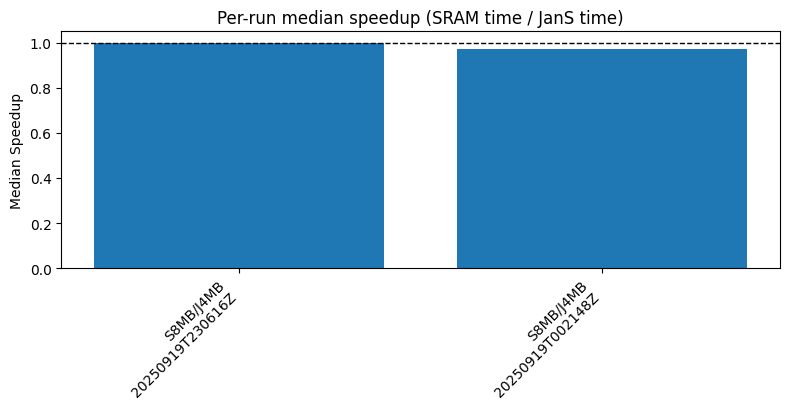

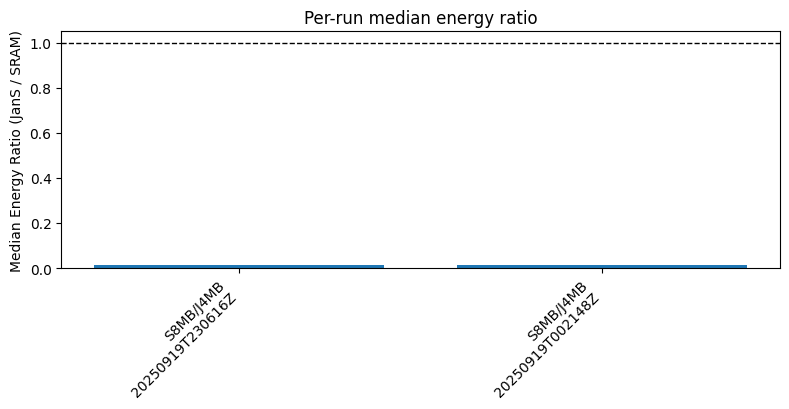

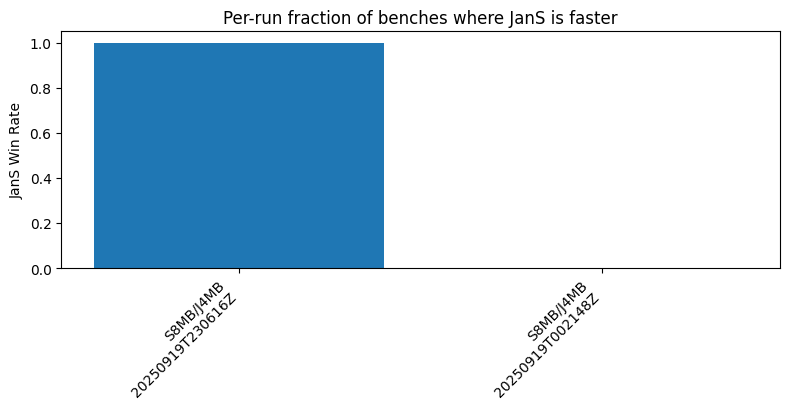

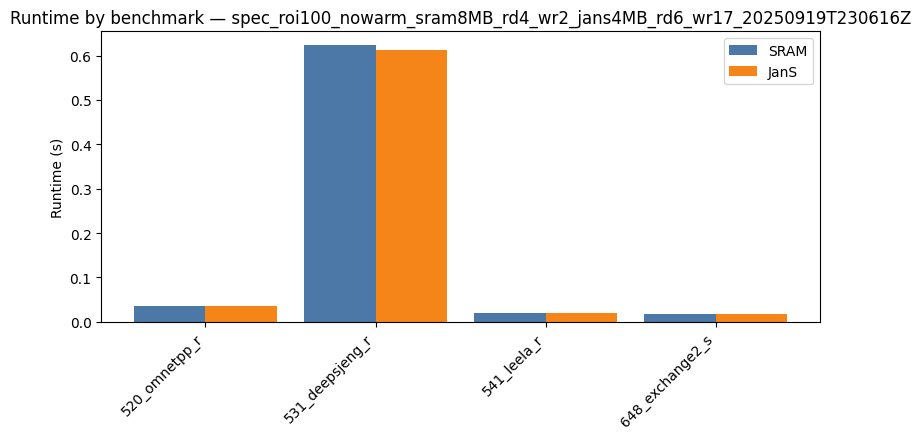

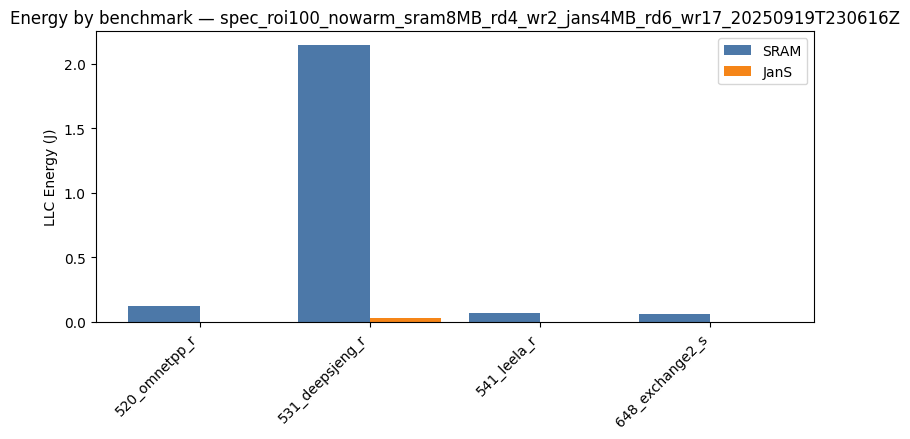

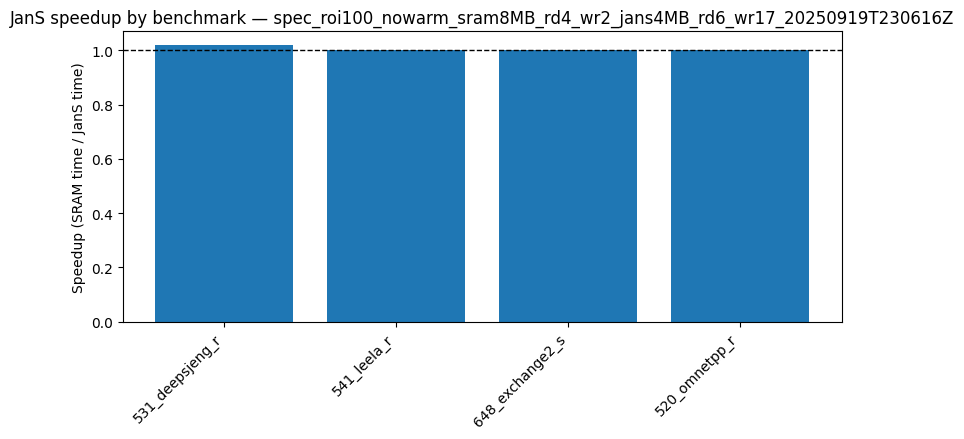

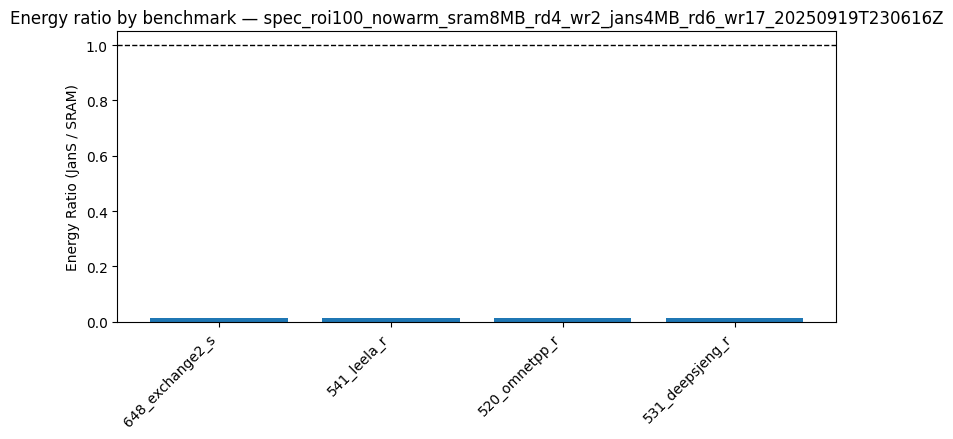

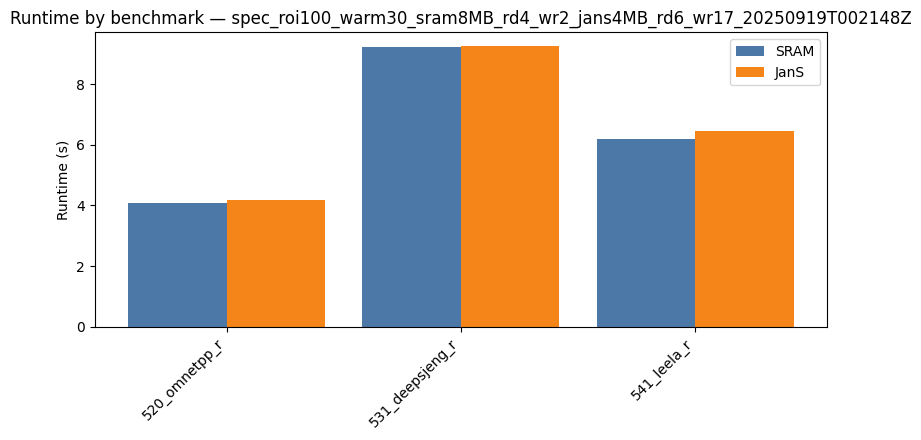

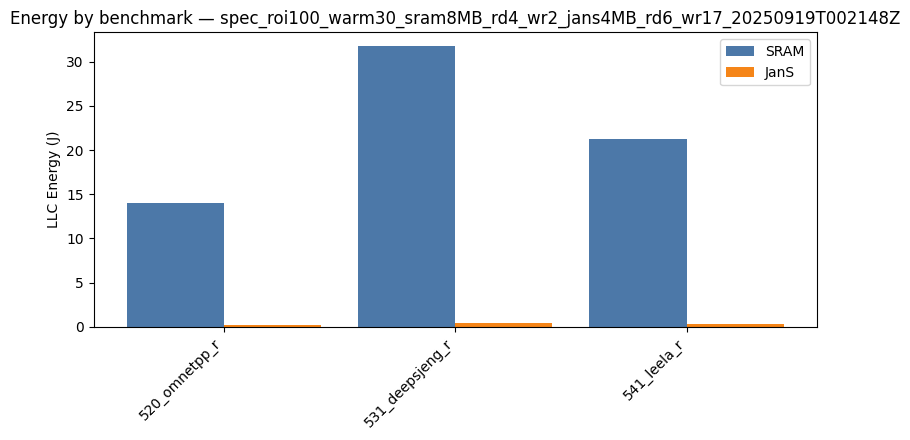

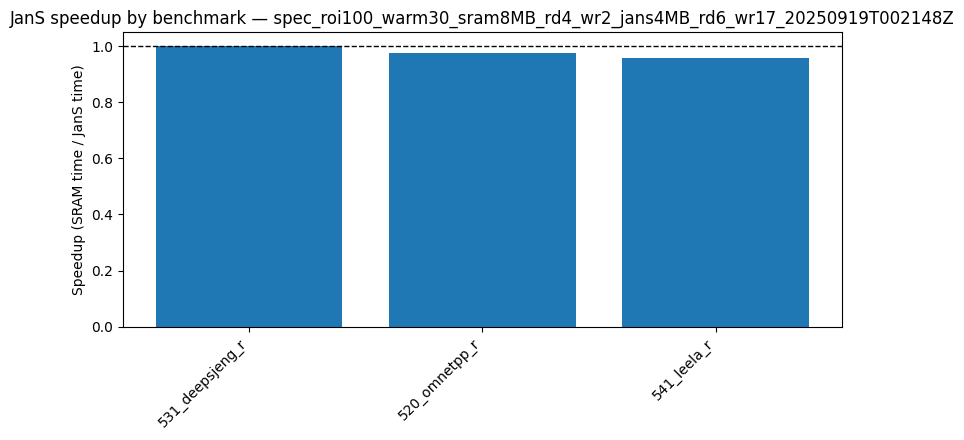

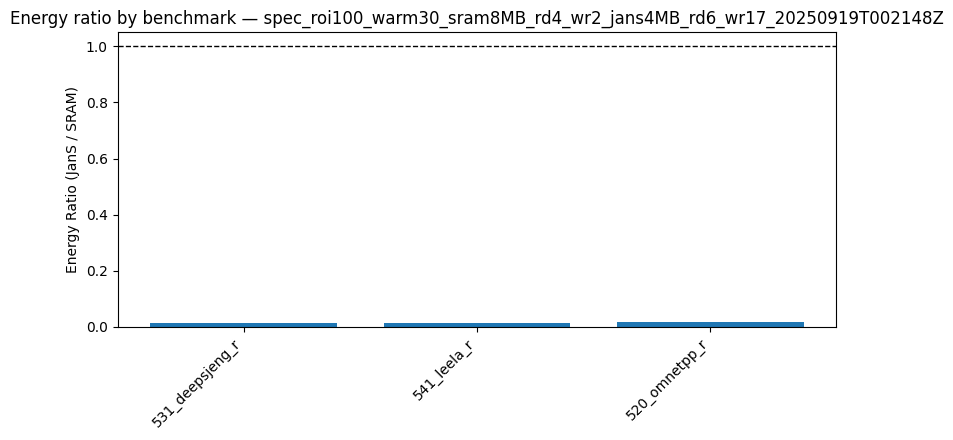

In [9]:
# Show per-run aggregates (one bar per run)
plot_aggregate_by_run_bars(bench_metrics_all)

# Loop over each discovered run and show normal bar charts
TOPK = None  # e.g., 20 to only show first 20 benches in each run
for rid in bench_metrics_all["run_id"].drop_duplicates():
    plot_per_run_runtime_bars(bench_metrics_all, rid, topk=TOPK)
    plot_per_run_energy_bars(bench_metrics_all,  rid, topk=TOPK)
    plot_per_run_speedup_bars(bench_metrics_all, rid, topk=TOPK)
    plot_per_run_energy_ratio_bars(bench_metrics_all, rid, topk=TOPK)


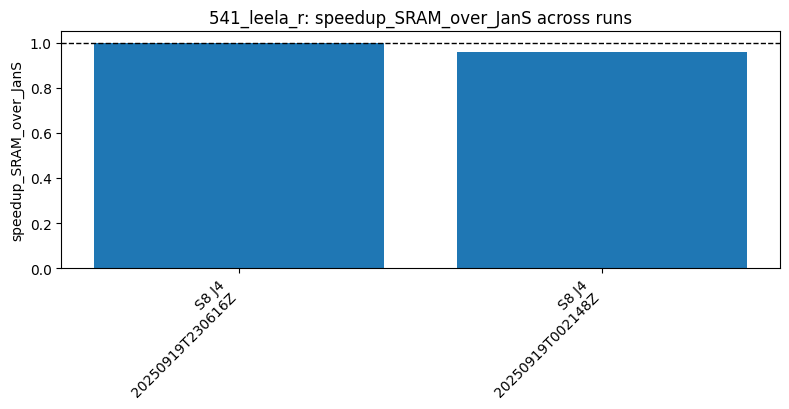

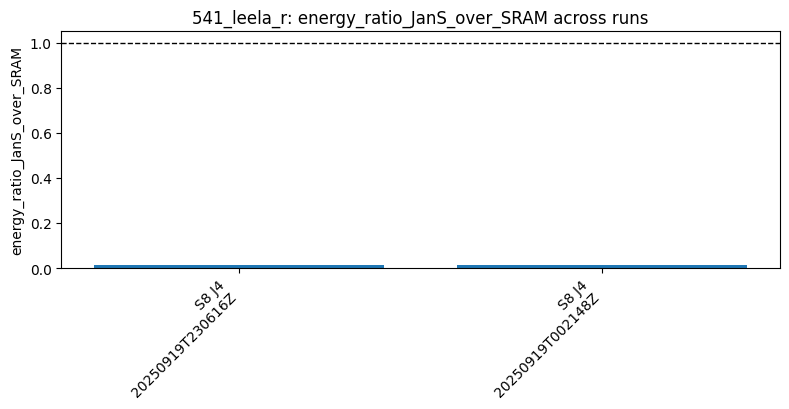

In [10]:
BENCH = "541_leela_r"  # change as needed
plot_bench_across_runs_bars(bench_metrics_all, BENCH, "speedup_SRAM_over_JanS")
plot_bench_across_runs_bars(bench_metrics_all, BENCH, "energy_ratio_JanS_over_SRAM")
